In [1]:
! pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=347ca56f026796faef9328f08f6b294dbb39c4b1bc8d5e8a8d914ba9e1885bb5
  Stored in directory: /home/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [17]:
%%time
import fastai
from fastai.vision.all import *
from pathlib import Path
from efficientnet_pytorch import EfficientNet

CPU times: user 2.43 ms, sys: 6.64 ms, total: 9.07 ms
Wall time: 6.94 ms


In [5]:
%%time
train = pd.read_csv("train-sample-split.csv", low_memory = False)

CPU times: user 11.3 ms, sys: 1.76 ms, total: 13.1 ms
Wall time: 10.4 ms


In [6]:
train.head()

,Unnamed: 0,image,species,individual_id,kfold,is_valid
0,10,001001f099519f.jpg,minke_whale,19fbb960f07d,0,False
1,29,002ac5f9ad7c10.jpg,false_killer_whale,f7bb4f9a9d1a,0,False
2,30,002e00960cec44.jpg,common_dolphin,e943980b7a98,0,False
3,44,004132b34ded14.jpg,humpback_whale,3e025417eb83,0,False
4,46,0044ec4ae5ecfd.jpg,killer_whale,e6388e8a7f58,0,True


In [7]:
path = Path.cwd()/"sample/"

In [10]:
whales = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_x = ColReader("image", path),
                   get_y = ColReader("individual_id"),
                   splitter = ColSplitter("is_valid"),
                   item_tfms = Resize(440),
                   batch_tfms = [*aug_transforms(size = 224, min_scale = 0.75)])

In [11]:
dls = whales.dataloaders(train)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


CPU times: user 8.77 s, sys: 751 ms, total: 9.52 s
Wall time: 9.3 s


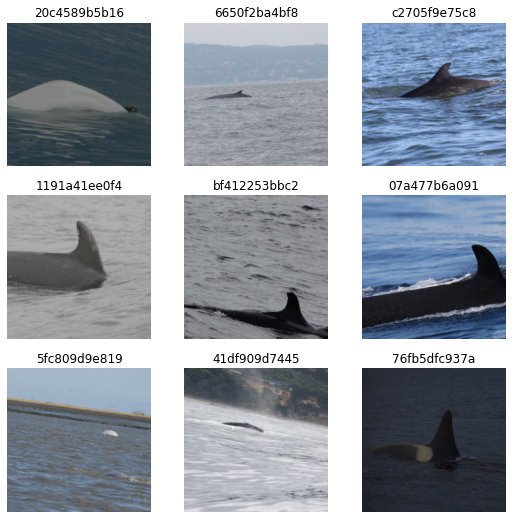

In [12]:
%%time

dls.show_batch()

In [14]:
dls.c

721

In [15]:
len(dls.vocab)

721

In [18]:
%%time
model = EfficientNet.from_name('efficientnet-b0')

CPU times: user 168 ms, sys: 12 ms, total: 180 ms
Wall time: 177 ms


In [21]:
model._fc = nn.Linear(1280, dls.c)

In [22]:
learn = Learner(dls, model, metrics = error_rate)

CPU times: user 15.3 s, sys: 10.8 s, total: 26.1 s
Wall time: 2min 30s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0008317637839354575)

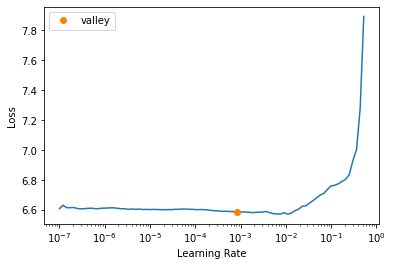

In [23]:
%%time
learn.lr_find()

In [24]:
%%time
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,6.619147,6.576293,0.992481,01:06
1,6.480447,6.545178,0.992481,01:04
2,6.304515,6.516457,0.992481,01:03
3,6.084046,6.506520,0.992481,01:05
4,5.895463,6.506101,0.992481,01:03


CPU times: user 28.5 s, sys: 18.6 s, total: 47 s
Wall time: 5min 24s


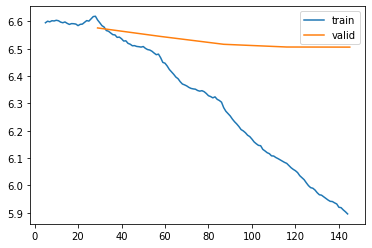

In [25]:
learn.recorder.plot_loss()

In [26]:
preds, act = learn.get_preds()

In [27]:
preds_sorted = []
for i in preds :
    temp = list(np.argsort(-i)[:5])
    preds_sorted.append(temp)

In [28]:
def map_per_image(predictions, label):
    '''this function will calculate MAP@5 for a single image

    predictions = list of top 5 predictions for an image (Order does matter).
    label = true label
    '''
    try :
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError :
        return 0.0



def map_per_set(predictions, labels):
    '''this function calculates MAP@5 for the whole set

    predictions = list of list of top 5 predictions for every image.
    labels = list of true labels 
    '''
    
    return np.mean([map_per_image(p, l) for p,l in zip(predictions, labels)])

In [29]:
map_per_set(preds_sorted, act)

0.017355889724310774

In [32]:
def map_per_set(predictions, labels):
    '''this function calculates MAP@5 for the whole set

    predictions = list of list of top 5 predictions for every image.
    labels = list of true labels 
    '''
    preds_sorted = []
    for i in predictions :
        temp = list(np.argsort(-i)[:5])
        preds_sorted.append(temp)
    return np.mean([map_per_image(p, l) for p,l in zip(preds_sorted, labels)])

In [33]:
map_per_set(preds, act)

0.017355889724310774

In [36]:
help(AccumMetric)

Help on class AccumMetric in module fastai.metrics:

class AccumMetric(fastai.learner.Metric)
 |  AccumMetric(func, dim_argmax=None, activation='no', thresh=None, to_np=False, invert_arg=False, flatten=True, **kwargs)
 |  
 |  Stores predictions and targets on CPU in accumulate to perform final calculations with `func`.
 |  
 |  Method resolution order:
 |      AccumMetric
 |      fastai.learner.Metric
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, preds, targs)
 |      Calculate metric on one batch of data
 |  
 |  __init__(self, func, dim_argmax=None, activation='no', thresh=None, to_np=False, invert_arg=False, flatten=True, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  accum_values(self, preds, targs, learn=None)
 |      Store targs and preds
 |  
 |  accumulate(self, learn)
 |      Store targs and preds from `learn`, using activation function and argmax as appropriate
 |  
 |  reset(self)
 |      Clear all 

In [37]:
map5 = AccumMetric(map_per_set, to_np = True, softmax = True)

In [38]:
learn = Learner(dls, model, metrics = [error_rate, map5])

In [39]:
learn.fit_one_cycle(2, 2e-3)

epoch,train_loss,valid_loss,error_rate,map_per_set,time


AssertionError: ==:
46144
64

In [51]:
map5 = AccumMetric(map_per_set, to_np = False,  flatten = False)

In [52]:
map5(preds, act)

0.017355889724310774

In [53]:
learn = Learner(dls, model, metrics = [error_rate, map5])

In [54]:
learn.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,error_rate,map_per_set,time
0,6.224531,6.561205,0.992481,0.017043,01:05


In [60]:
Path("/home/sample").ls()

(#5105) [Path('/home/sample/001001f099519f.jpg'),Path('/home/sample/00021adfb725ed.jpg'),Path('/home/sample/001cfade605960.jpg'),Path('/home/sample/002618d6f63ebc.jpg'),Path('/home/sample/002ac5f9ad7c10.jpg'),Path('/home/sample/002e00960cec44.jpg'),Path('/home/sample/004132b34ded14.jpg'),Path('/home/sample/0042dfc65c7987.jpg'),Path('/home/sample/0044ec4ae5ecfd.jpg'),Path('/home/sample/00665aba3c163b.jpg')...]